In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from ncf import *

device ='cuda:0'
ncf_model_path = "../data/flickr/evaluation/classifier/"
ncf_model_file = "ncf_usrthrs_0.pkl"

ncf = NCF()
ncf.load(f"{ncf_model_path}/{ncf_model_file}")

In [2]:
data_eval = pd.read_csv(f"../data/flickr/processed/test/test_usrthrs_0.csv")
E_test = torch.load(f"../data/flickr/processed/test/test_ie_sdxl.pt", weights_only=True)
E_train = torch.load(f"../data/flickr/processed/train/train_ie_sdxl.pt", weights_only=True)
#E_test = torch.load(f"../data/flickr/processed/test/test_ie_usrthrs_0.pt", weights_only=True)
data_train = pd.read_csv(f"../data/flickr/processed/train/train_usrthrs_0.csv")
#E_train = torch.load(f"../data/flickr/processed/train/train_ie_usrthrs_0.pt", weights_only=True)
Y_test = (torch.tensor(data_eval.score)>=4).float()
Y_train = (torch.tensor(data_train.score)>=4).float()
U_test = torch.tensor(data_eval.worker_id)
U_train = torch.tensor(data_train.worker_id)

In [5]:
E_train.dtype


torch.float16

In [8]:
ncf.model

NCFModel(
  (user_embedding_gmf): Embedding(210, 320)
  (user_bias): Embedding(210, 1)
  (item_transform_gmf): Linear(in_features=1024, out_features=320, bias=True)
  (item_bias): Linear(in_features=1024, out_features=1, bias=True)
  (user_embedding_mlp): Embedding(210, 320)
  (item_transform_mlp): Linear(in_features=1024, out_features=320, bias=True)
  (mlp_layers): ModuleList(
    (0): Linear(in_features=640, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (final_layer): Linear(in_features=352, out_features=1, bias=True)
)

In [9]:
from sklearn import metrics

In [5]:
metrics.accuracy_score( ncf.predict(U_train, E_train).numpy()>0.5, Y_train.bool().numpy())

0.8338641750613731

In [6]:
metrics.accuracy_score( ncf.predict(U_test, E_test).numpy()>0.5, Y_test.bool().numpy())

0.8047619047619048

In [7]:
Y_test.numpy()

array([0., 0., 0., ..., 0., 0., 0.], shape=(2100,), dtype=float32)

In [8]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test.numpy(), ncf.predict(U_test, E_test).numpy())
print(metrics.auc(fpr, tpr))

0.8755865668232805


In [9]:
Y_test.size(0)

2100

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from sklearn import metrics
from sklearn.metrics import roc_curve

def bootstrap_auc(ncf_model, Y_test, U_test, E_test, Y_train, U_train, E_train,
                  B=1000, seed=42, savebase=None):
    # ---- CVPR-style aesthetics ----
    mpl.rcParams.update({
        "font.family": "serif",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 22,     # bigger titles
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14,
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.dpi": 300,
        "savefig.transparent": True,
    })
    sns.set_style("whitegrid")

    rng = np.random.default_rng(seed)
    n = Y_test.size(0)
    AUCs = []

    # ---- Bootstrap AUCs ----
    with torch.no_grad():
        for _ in range(B):
            idx = torch.as_tensor(rng.integers(0, n, size=n), device=Y_test.device)
            y_b = Y_test[idx].detach().cpu().numpy()
            u_b = U_test[idx]
            e_b = E_test[idx]
            yhat_b = ncf_model.predict(u_b, e_b).detach().cpu().numpy()
            AUCs.append(metrics.roc_auc_score(y_b, yhat_b))

    AUCs = np.array(AUCs)
    se = AUCs.std(ddof=1)
    ci_lo, ci_hi = np.percentile(AUCs, [2.5, 97.5])

    with torch.no_grad():
        y_test = Y_test.detach().cpu().numpy()
        yhat_test = ncf_model.predict(U_test, E_test).detach().cpu().numpy()
        auc_test = metrics.roc_auc_score(y_test, yhat_test)

        y_train = Y_train.detach().cpu().numpy()
        yhat_train = ncf_model.predict(U_train, E_train).detach().cpu().numpy()
        auc_train = metrics.roc_auc_score(y_train, yhat_train)

    print(f"Bootstrap Test AUC: mean={AUCs.mean():.4f}, SE={se:.4f}, 95% CI=[{ci_lo:.4f}, {ci_hi:.4f}]")
    print(f"Test AUC:  {auc_test:.4f}")
    print(f"Train AUC: {auc_train:.4f}")

    # ---- Curves & histogram (CVPR look) ----
    fpr_test,  tpr_test,  _ = roc_curve(y_test,  yhat_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, yhat_train)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

    # (A) ROC curves — clean, legible, balanced
    ax = axes[0]
    ax.plot([0, 1], [0, 1], ls="--", lw=1.2, label="Chance")
    ax.plot(fpr_train, tpr_train, lw=2, label=f"Train (AUC={auc_train:.3f})")
    ax.plot(fpr_test,  tpr_test,  lw=2, label=f"Test (AUC={auc_test:.3f})")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves", weight="bold", pad=10)
    ax.legend(frameon=False, loc="lower right")
    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=0.25)

    # (B) Bootstrap AUC distribution — styled like your histplots
    ax = axes[1]
    sns.histplot(AUCs, bins=40, kde=False, color="#4C9BE8",
                 edgecolor="white", lw=0.4, ax=ax)
    ax.axvline(auc_test,  color="red", ls="-",  lw=2, label=f"Test = {auc_test:.3f}")
    ax.axvline(auc_train, color="red", ls="--", lw=2, label=f"Train = {auc_train:.3f}")
    ax.axvspan(ci_lo, ci_hi, alpha=0.18, label=f"95% CI [{ci_lo:.3f}, {ci_hi:.3f}]")
    # Ticks: fewer, formatted, with gentle padding
    lo = float(min(AUCs.min(), auc_test, auc_train))
    hi = float(max(AUCs.max(), auc_test, auc_train))
    pad = max(1e-4, 0.12 * (hi - lo))
    ax.set_xlim(lo - pad, hi + pad)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax.set_xlabel("Bootstrapped Test AUC")
    ax.set_ylabel("Count")
    ax.set_title(f"Test AUC Bootstrap (SE ≈ {se:.4f})", weight="bold", pad=10)
    ax.legend(frameon=False, loc="upper left")
    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=0.25)

    plt.tight_layout(w_pad=2.8)

    if savebase is not None:
        plt.savefig(f"{savebase}.pdf", bbox_inches="tight")
        plt.savefig(f"{savebase}.png", bbox_inches="tight", dpi=600)

    plt.show()

    return {
        "auc_train": float(auc_train),
        "auc_test": float(auc_test),
        "boot_mean": float(AUCs.mean()),
        "boot_se": float(se),
        "ci": (float(ci_lo), float(ci_hi)),
        "AUCs": AUCs,
    }


In [11]:
print(ncf.d, ncf.lr, ncf.wd, ncf.gamma, ncf.mlp_layers, ncf.dropout)


320 0.0001 0.01 0.9999 [64, 32] 0.1


In [19]:

U_train = U_train.to("cuda", dtype=torch.long)
E_train = E_train.to("cuda", dtype=torch.float32)
Y_train = Y_train.to("cuda", dtype=torch.float32)

E_test = E_test.to("cuda", dtype=torch.float32)
U_test = U_test.to("cuda", dtype=torch.long)
Y_test = Y_test.to("cuda", dtype=torch.float32)


In [75]:
from ncf import train_ncf

mlp_layers = [128, 128]

In [80]:
training_results = train_ncf(
    U=U_train,
    E=E_train,
    Y=Y_train,
    d=480,
    mlp_layers=mlp_layers,
    lr=5e-6,
    dropout=0.2,
    gamma=0.1,
    wd=ncf.wd,
    random_state=42,
    device="cuda",
    patience=10
)

test


Training NCF:   0%|          | 0/10000 [00:00<?, ?it/s]

NCF - lr 5e-06 -- d 480 -- wd 0.01 -- gamma 0.1 -- val_loss: 0.4274519979953766


Bootstrap Test AUC: mean=0.8673, SE=0.0079, 95% CI=[0.8513, 0.8820]
Test AUC:  0.8672
Train AUC: 0.8785


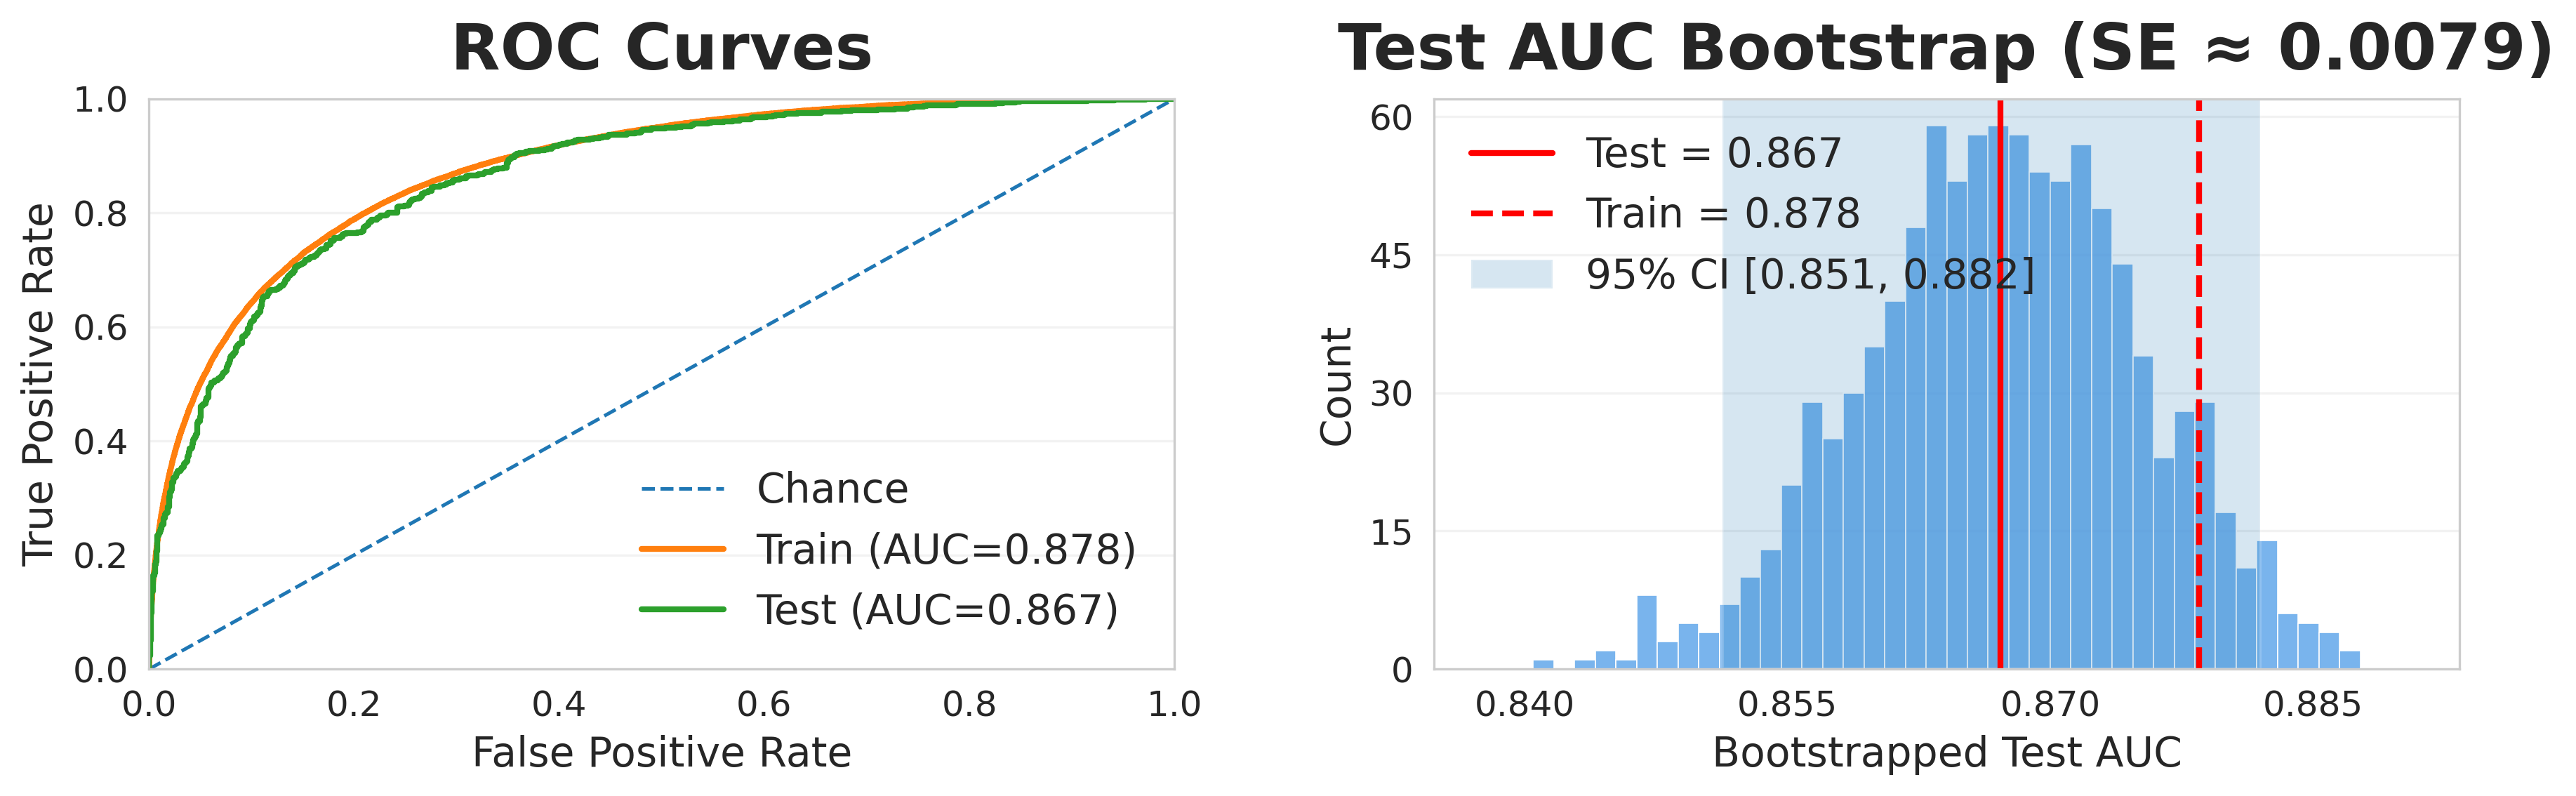

{'auc_train': 0.8784898746992762,
 'auc_test': 0.8671670599168145,
 'boot_mean': 0.8672872693397293,
 'boot_se': 0.007909137972416868,
 'ci': (0.851294012996139, 0.8819798421200887),
 'AUCs': array([0.87204956, 0.86473669, 0.86940693, 0.86612525, 0.86353184,
        0.88001542, 0.8742077 , 0.86537392, 0.85602255, 0.86996407,
        0.85175177, 0.8800116 , 0.87126601, 0.87769757, 0.86080638,
        0.87325552, 0.86753826, 0.86550913, 0.86571   , 0.88292464,
        0.86768109, 0.87681522, 0.88110018, 0.88003954, 0.86280835,
        0.8656939 , 0.86600365, 0.85387766, 0.87360806, 0.87319875,
        0.8684843 , 0.87094621, 0.86312412, 0.86364275, 0.87066415,
        0.86332926, 0.85971845, 0.88197481, 0.87730567, 0.87085798,
        0.86946606, 0.84958331, 0.84668123, 0.86290193, 0.86422503,
        0.87488842, 0.86458089, 0.85298872, 0.87082574, 0.86561531,
        0.87547474, 0.86200176, 0.87801546, 0.86051151, 0.85596836,
        0.85725897, 0.85938866, 0.86330642, 0.87425414, 0.871

In [81]:
from ncf import NCF
from sklearn import metrics
curr_ncf = NCF( 
    mlp_layers=ncf.mlp_layers, 
    dropout=0.2)

curr_ncf.model = training_results["model"].to(device)

curr_ncf.predict(U_test.to(device),E_test.to(device))

bootstrap_auc(
    ncf_model=curr_ncf,
    Y_test=Y_test.to(device),
    U_test=U_test.to(device),
    E_test=E_test.to(device),
    Y_train=Y_train.to(device),
    U_train=U_train.to(device),
    E_train=E_train.to(device),
    savebase="./outputs/ncf/diagnostics"
)

In [84]:
import pickle

path = "../data/flickr/evaluation/classifier/ncf_scorer_ViT-G.pkl"

with open(path, 'wb') as f:
            pickle.dump({
                'd': 480,
                'lr':5e-6,
                'wd': 0.01,
                'gamma': 0.1,
                'mlp_layers':[128, 128],
                'dropout': 0.2,
                'model_state_dict': training_results["model"].state_dict(),
                'model_config': {
                    'num_users': 210,
                    'emb_dim': 1280,
                    'd': 480,
                    'mlp_layers': [128, 128],
                    'dropout': 0.2
                },
                'best_val_loss': training_results["best_val_loss"],
                'validation':None
            }, f)

In [41]:
import pickle

path = "../data/flickr/evaluation/classifier/ncf_scorer.pkl"

with open(path, 'wb') as f:
            pickle.dump({
                'd': 480,
                'lr':1e-5,
                'wd': 0.01,
                'gamma': 0.1,
                'mlp_layers':[64, 64],
                'dropout': 0.25,
                'model_state_dict': training_results["model"].state_dict(),
                'model_config': {
                    'num_users': 210,
                    'emb_dim': 1024,
                    'd': 480,
                    'mlp_layers': [64, 64],
                    'dropout': 0.25
                },
                'best_val_loss': training_results["best_val_loss"],
                'validation':None
            }, f)

In [36]:
test_ncf = NCF()
test_ncf.load(path)

In [39]:
U_test

tensor([  0,   0,   0,  ..., 209, 209, 209])

In [40]:
test_ncf.predict(U_test.to(device), E_test.to(device))

tensor([0.1979, 0.0252, 0.0294,  ..., 0.0534, 0.0209, 0.2153], device='cuda:0')

In [33]:
test_ncf